In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/DDD')
os.getcwd() #查看當前路徑

'/content/gdrive/MyDrive/DDD'

In [ ]:
!ls

DDD.ipynb	      sample_submission.csv
driver_imgs_list.csv  train_image.pickle
image_label.pickle    xception_imagenet_split_on_subject.h5
imgs.zip


In [ ]:
import pandas as pd
import os, shutil
import cv2

driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head())

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
import pickle

with open('train_image.pickle','rb') as f1:
  train_image = pickle.load(f1)

In [ ]:
len(train_image)

22424

In [ ]:
import random
random.shuffle(train_image)

In [ ]:
drivers = []
for F,L,D in train_image:
    drivers.append(D)
drivers = list(set(drivers))
len(drivers)

26

In [ ]:
drivers[:4]

['p002', 'p041', 'p050', 'p052']

# Split on subjects

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
drivers_train = []
drivers_val = []

for F,L,D in train_image:
    if D in drivers[:4]:
        drivers_val.append(D)
        x_val.append(F)
        y_val.append(L)
    else:
        drivers_train.append(D)
        x_train.append(F)
        y_train.append(L)

print(len(x_train))
print(len(x_val))

19564
2860


In [ ]:
import numpy as np

# Converting images to nparray
x_train = np.array(x_train).reshape(-1,140,140,3) #等於.reshape(19181,140,140,3)
x_val = np.array(x_val).reshape(-1,140,140,3)

print (x_train.shape)

(19564, 140, 140, 3)


In [ ]:
import tensorflow as tf

tf.__version__

'2.4.0'

In [ ]:
# one_hot_encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

print(y_train.shape)

(19564, 10)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
from tensorflow.keras.applications.xception import Xception

Xception_Conv = Xception(weights= 'imagenet', include_top=False, input_shape= (140,140,3))
Xception_Conv.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 69, 69, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 69, 69, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
Xception_input = tf.keras.layers.Input(shape=(140,140,3), name='Image_Input')
Xception_output = Xception_Conv(Xception_input)
x = tf.keras.layers.Flatten()(Xception_output)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=Xception_input, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 140, 140, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                512010    
Total params: 21,373,490
Trainable params: 21,318,962
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
#@title
#model = tf.keras.Sequential([
#    Xception_Conv,
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(10, activation='softmax', name='predictions')
#])
#
#model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('xception_imagenet_split_on_subject.h5', monitor='val_loss', save_best_only=True)
#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2 )
#callbacks_list = [checkpointer, earlystopper]


datagen = tf.keras.preprocessing.image.ImageDataGenerator()

data_generator = datagen.flow(x_train, y_train, batch_size = 32)
xception_model = model.fit_generator(
    data_generator,steps_per_epoch = len(x_train)/32,
    epochs = 10,
    validation_data = (x_val,y_val),
    callbacks = checkpointer)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
611/611 [==============================] - 173s 264ms/step - loss: 1.1530 - accuracy: 0.5965 - val_loss: 2.5870 - val_accuracy: 0.4983
Epoch 2/10
611/611 [==============================] - 166s 271ms/step - loss: 0.0967 - accuracy: 0.9741 - val_loss: 2.0687 - val_accuracy: 0.5972
Epoch 3/10
611/611 [==============================] - 167s 274ms/step - loss: 0.0579 - accuracy: 0.9849 - val_loss: 1.0869 - val_accuracy: 0.7552
Epoch 4/10
611/611 [==============================] - 168s 275ms/step - loss: 0.0535 - accuracy: 0.9870 - val_loss: 0.8354 - val_accuracy: 0.7934
Epoch 5/10
611/611 [==============================] - 168s 275ms/step - loss: 0.0315 - accuracy: 0.9915 - val_loss: 1.2156 - val_accuracy: 0.7808
Epoch 6/10
611/611 [==============================] - 169s 277ms/step - loss: 0.0370 - accuracy: 0.9903 - val_loss: 2.5863 - val_accuracy: 0.6458
Epoch 7/10
611/611 [==============================] - 169s 277ms/step - loss: 0.0318 - accuracy: 0.9914 - val_loss: 0.6049 -

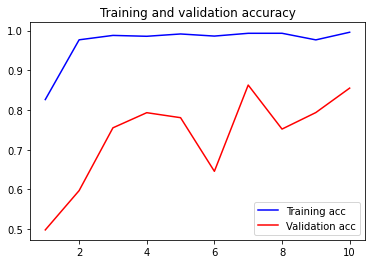

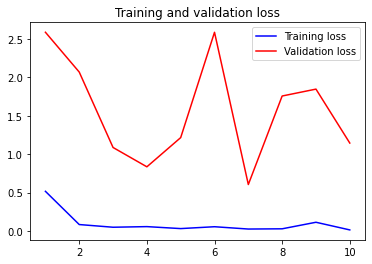

In [ ]:
import matplotlib.pyplot as plt

acc = xception_model.history['accuracy']
val_acc = xception_model.history['val_accuracy']
loss = xception_model.history['loss']
val_loss = xception_model.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
with open('Xception_imagenet_acc.pickle','wb') as f:
  pickle.dump([acc,val_acc,loss,val_loss],f)

In [ ]:
with open('Xception_imagenet_acc.pickle','rb') as f:
  [acc,val_acc,loss,val_loss] = pickle.load(f)

print(acc)

[0.8264158368110657, 0.9767941236495972, 0.9878858923912048, 0.9856879711151123, 0.991515040397644, 0.986199140548706, 0.9932017922401428, 0.9932529330253601, 0.9766407608985901, 0.9958597421646118]


In [ ]:
print(acc)
print(val_acc)

[0.8264158368110657, 0.9767941236495972, 0.9878858923912048, 0.9856879711151123, 0.991515040397644, 0.986199140548706, 0.9932017922401428, 0.9932529330253601, 0.9766407608985901, 0.9958597421646118]
[0.498251736164093, 0.5972027778625488, 0.7552447319030762, 0.7933566570281982, 0.7807692289352417, 0.6458041667938232, 0.8629370331764221, 0.7520979046821594, 0.7937062978744507, 0.8552447557449341]
